<a href="https://colab.research.google.com/github/nathsteve13/tugas-akhir/blob/main/ta_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shutil, unicodedata
from PIL import Image, UnidentifiedImageError

In [3]:
DATA_DIR = "/content/drive/MyDrive/dataset_babybrandedshop"
import os
assert os.path.isdir(DATA_DIR), f"Folder dataset tidak ditemukan: {DATA_DIR}"
print("OK. Dataset folder ditemukan:", DATA_DIR)

OK. Dataset folder ditemukan: /content/drive/MyDrive/dataset_babybrandedshop


In [4]:
from pathlib import Path
import imghdr
import os


image_extensions = [".png", ".jpg", ".jpeg", ".gif", ".bmp", ".tif", ".tiff", ".webp"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

count_checked = 0
count_deleted = 0
count_error = 0

for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.is_file() and filepath.suffix.lower() in image_extensions:
        count_checked += 1
        img_type = imghdr.what(filepath)

        if img_type is None or img_type not in img_type_accepted_by_tf:
            try:
                os.remove(filepath)
                print(f"[DELETED] {filepath} ({img_type})")
                count_deleted += 1
            except Exception as e:
                print(f"❌ Gagal menghapus {filepath}: {e}")
                count_error += 1

print("\n✅ Selesai.")
print(f"Total file dicek     : {count_checked}")
print(f"Total file dihapus   : {count_deleted}")
print(f"Total gagal dihapus  : {count_error}")


/tmp/ipython-input-1329616868.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr



✅ Selesai.
Total file dicek     : 3346
Total file dihapus   : 0
Total gagal dihapus  : 0


In [5]:
from pathlib import Path

TF_SUPPORTED = {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
CONVERTIBLE  = {".webp", ".jfif", ".tif", ".tiff"}
data_path = Path(DATA_DIR)

class_dirs = [p for p in data_path.iterdir() if p.is_dir()]
class_names = sorted([p.name for p in class_dirs])

print(f"Jumlah kelas: {len(class_names)}")
print("Kelas:", class_names)

counts = {}
total = 0
for c in class_dirs:
    n = sum(1 for f in c.rglob("*") if f.suffix.lower() in TF_SUPPORTED)
    counts[c.name] = n
    total += n

print("\nRingkasan jumlah file per kelas:")
for k, v in counts.items():
    print(f"- {k}: {v}")
print(f"\nTotal gambar: {total}")

Jumlah kelas: 12
Kelas: ['.ipynb_checkpoints', 'backpack', 'bottlepacifier', 'boy16y', 'boy36m', 'girl16y', 'girl36m', 'hat', 'shoes', 'socks', 'stroller', 'swimsuit']

Ringkasan jumlah file per kelas:
- swimsuit: 311
- girl36m: 270
- backpack: 303
- shoes: 315
- socks: 350
- boy36m: 318
- hat: 300
- girl16y: 250
- stroller: 298
- bottlepacifier: 299
- boy16y: 332
- .ipynb_checkpoints: 0

Total gambar: 3346


In [6]:
IMG_SIZE   = (256, 256)
BATCH_SIZE = 32
VAL_SPLIT  = 0.2
SEED       = 42
AUTOTUNE   = tf.data.AUTOTUNE

In [7]:
preprocess = keras.Sequential([
    layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
    layers.Rescaling(1./255),
], name="preprocess")

augment = keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor=0.0833, fill_mode="reflect"),
    layers.RandomZoom(height_factor=(-0.10, 0.10), width_factor=(-0.10, 0.10)),
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=0.1),
], name="augment")


In [8]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    str(DATA_DIR),
    labels="inferred",
    label_mode="categorical",
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    str(DATA_DIR),
    labels="inferred",
    label_mode="categorical",
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
class_names = train_ds.class_names
num_classes = len(class_names)
print("Kelas:", class_names, "| num_classes:", num_classes)


Found 3346 files belonging to 11 classes.
Using 2677 files for training.
Found 3346 files belonging to 11 classes.
Using 669 files for validation.
Kelas: ['backpack', 'bottlepacifier', 'boy16y', 'boy36m', 'girl16y', 'girl36m', 'hat', 'shoes', 'socks', 'stroller', 'swimsuit'] | num_classes: 11


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Bentuk gambar: (32, 256, 256, 3)
Bentuk label: (32, 11)


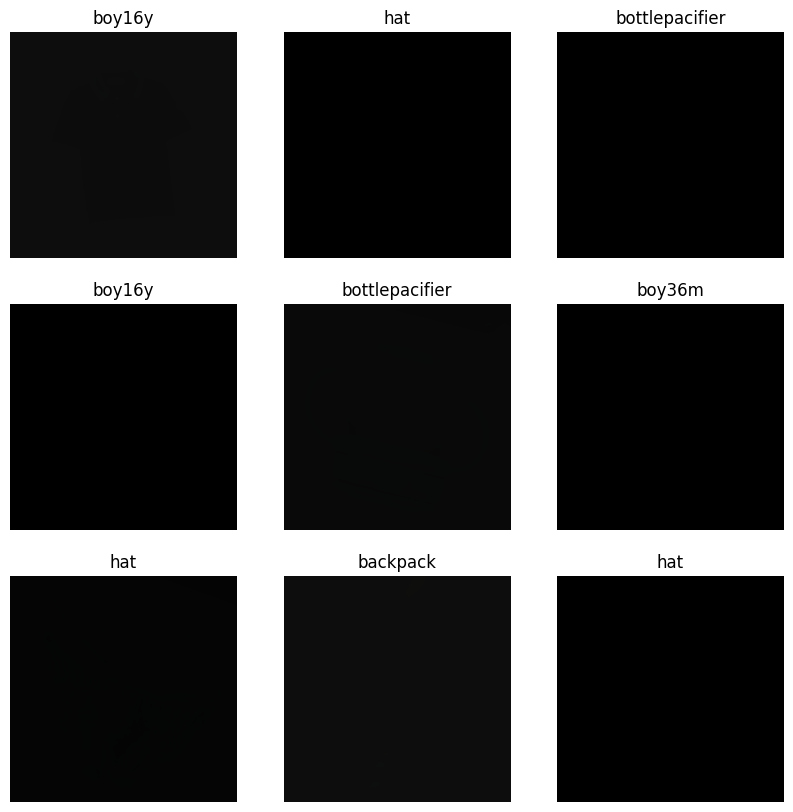

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in train_ds.take(1):
    print("Bentuk gambar:", images.shape)
    print("Bentuk label:", labels.shape)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

        class_index = np.argmax(labels[i].numpy())
        plt.title(class_names[class_index])
    plt.show()


In [13]:
IMG_SHAPE = (256, 256, 3)
NUM_CLASSES = 11
LR = 1e-4

In [14]:
# ====== 1) Encoder–Decoder (CAE) ======
def build_cae(img_shape=IMG_SHAPE):
    inp = keras.Input(shape=img_shape)

    # ----- ENCODER (sesuai gambar: Conv16 -> MP -> Conv8 -> MP -> Conv8 -> MP) -----
    x = layers.Conv2D(16, 3, padding="same", activation="relu", name="enc_conv1")(inp)
    x = layers.MaxPool2D(pool_size=2, name="enc_pool1")(x)

    x = layers.Conv2D(8, 3, padding="same", activation="relu", name="enc_conv2")(x)
    x = layers.MaxPool2D(pool_size=2, name="enc_pool2")(x)

    x = layers.Conv2D(8, 3, padding="same", activation="relu", name="enc_conv3")(x)
    bottleneck = layers.MaxPool2D(pool_size=2, name="enc_pool3")(x)   # -> BOTTLENECK 32×32×8

    # ----- DECODER (simetris, transposed conv) -----
    y = layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu", name="dec_deconv1")(bottleneck)
    y = layers.Conv2D(8, 3, padding="same", activation="relu", name="dec_conv1")(y)

    y = layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu", name="dec_deconv2")(y)
    y = layers.Conv2D(8, 3, padding="same", activation="relu", name="dec_conv2")(y)

    y = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu", name="dec_deconv3")(y)
    y = layers.Conv2D(16, 3, padding="same", activation="relu", name="dec_conv3")(y)

    out = layers.Conv2D(3, 3, padding="same", activation="sigmoid", name="reconstruction")(y)

    cae = keras.Model(inp, out, name="CAE")
    encoder = keras.Model(inp, bottleneck, name="CAE_encoder")
    return cae, encoder

cae, encoder = build_cae()

In [15]:
# ====== 2) Compile CAE (Eq. 2.13: MSE) ======
cae.compile(optimizer=keras.optimizers.Adam(LR),
            loss="mse",
            metrics=[keras.metrics.MeanAbsoluteError(name="mae")])

In [16]:
# ====== 3) Siapkan dataset AE: (x, x) ======
def to_ae_pairs(x, y):
    return x, x

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
cae_train = train_ds.map(to_ae_pairs, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
cae_val   = val_ds.map(to_ae_pairs,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [18]:
# ====== 4) Pre-train CAE ======
callbacks_ae = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint("cae_best.keras", save_best_only=True, monitor="val_loss"),
]
history_ae = cae.fit(cae_train, validation_data=cae_val, epochs=30, callbacks=callbacks_ae)


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - loss: 0.2234 - mae: 0.4715 - val_loss: 0.2337 - val_mae: 0.4834 - learning_rate: 1.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step - loss: 0.1989 - mae: 0.4435 - val_loss: 0.0803 - val_mae: 0.2786 - learning_rate: 1.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0267 - mae: 0.1307 - val_loss: 0.0020 - val_mae: 0.0241 - learning_rate: 1.0000e-04
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0028 - mae: 0.0380 - val_loss: 9.4172e-04 - val_mae: 0.0099 - learning_rate: 1.0000e-04
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0023 - mae: 0.0311 - val_loss: 5.2697e-04 - val_mae: 0.0060 - learning_rate: 1.0000e-04
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0021 - mae: 0.0297 - val_loss: 2.7956e-04 - val_mae: 0.0049 - learning_rate: 1.0000e-04
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.0018 - mae: 0.0261 - val_loss: 1.3029e-04 - val_ma

In [19]:
# ====== 5) CNN Classifier di atas BOTTLENECK (sesuai blok bawah gambar) ======
def build_classifier(encoder_model, num_classes=NUM_CLASSES):
    encoder_model.trainable = False  # freeze saat fine-tune awal

    inp = keras.Input(shape=IMG_SHAPE, name="clf_input")
    z = encoder_model(inp)  # bottleneck: 32×32×8

    x = layers.Conv2D(6, 3, padding="same", activation="relu", name="clf_conv7")(z)
    x = layers.MaxPool2D(2, name="clf_pool4")(x)

    x = layers.Conv2D(16, 3, padding="same", activation="relu", name="clf_conv8")(x)
    x = layers.MaxPool2D(2, name="clf_pool5")(x)

    x = layers.Conv2D(16, 3, padding="same", activation="relu", name="clf_conv9")(x)
    x = layers.MaxPool2D(2, name="clf_pool6")(x)

    x = layers.Flatten(name="clf_flatten")(x)
    x = layers.Dense(32, activation="relu", name="clf_dense1")(x)

    out = layers.Dense(num_classes, activation="softmax", name="clf_output")(x)

    model = keras.Model(inp, out, name="Hybrid_CAE_CNN")
    return model

clf = build_classifier(encoder)

In [20]:
# ====== 6) Compile classifier (Eq. 2.14: Cross-Entropy) ======
clf.compile(optimizer=keras.optimizers.Adam(LR),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

# Dataset untuk klasifikasi: gunakan (x, y) asli (bukan (x, x))
clf_train = train_ds.prefetch(AUTOTUNE)
clf_val   = val_ds.prefetch(AUTOTUNE)

In [21]:
# ====== 7) Fine-tune tahap-1 (encoder frozen) ======
callbacks_clf = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint("hybrid_head_frozen.keras", save_best_only=True, monitor="val_accuracy"),
]
history_clf_stage1 = clf.fit(clf_train, validation_data=clf_val, epochs=20, callbacks=callbacks_clf)


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.0936 - loss: 2.4030 - val_accuracy: 0.0822 - val_loss: 2.4036 - learning_rate: 1.0000e-04
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0879 - loss: 2.3973 - val_accuracy: 0.0822 - val_loss: 2.4006 - learning_rate: 1.0000e-04
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0910 - loss: 2.3964 - val_accuracy: 0.0822 - val_loss: 2.4002 - learning_rate: 1.0000e-04
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1088 - loss: 2.3971 - val_accuracy: 0.1001 - val_loss: 2.3997 - learning_rate: 1.0000e-04
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1050 - loss: 2.3961 - val_accuracy: 0.1001 - val_loss: 2.3986 - learning_rate: 1.0000e-04
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1002 - loss: 2.3957 - val_accuracy: 0.1001 - val_loss: 2.3984 - learning_rate: 1.0000e-04
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1011 

In [22]:
# ====== 8) Fine-tune tahap-2 (unfreeze sebagian encoder) ======
# Buka blok terakhir encoder agar representasi menyesuaikan task
for layer in encoder.layers[-4:]:   # sesuaikan kedalaman pembukaan
    layer.trainable = True

clf.compile(optimizer=keras.optimizers.Adam(LR * 0.5),  # LR lebih kecil
            loss="categorical_crossentropy",
            metrics=["accuracy"])

callbacks_clf_stage2 = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint("hybrid_finetuned.keras", save_best_only=True, monitor="val_accuracy"),
]
history_clf_stage2 = clf.fit(clf_train, validation_data=clf_val, epochs=20, callbacks=callbacks_clf_stage2)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.1096 - loss: 2.3959 - val_accuracy: 0.1001 - val_loss: 2.3997 - learning_rate: 5.0000e-05
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1034 - loss: 2.3962 - val_accuracy: 0.1001 - val_loss: 2.3994 - learning_rate: 5.0000e-05
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1106 - loss: 2.3962 - val_accuracy: 0.1001 - val_loss: 2.3992 - learning_rate: 5.0000e-05
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1206 - loss: 2.3942 - val_accuracy: 0.1001 - val_loss: 2.3989 - learning_rate: 5.0000e-05
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1053 - loss: 2.3945 - val_accuracy: 0.1001 - val_loss: 2.3986 - learning_rate: 5.0000e-05
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1085 - loss: 2.3954 - val_accuracy: 0.1001 - val_loss: 2.3984 - learning_rate: 5.0000e-05
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1050 

In [23]:
final_metrics = clf.evaluate(clf_val, verbose=0)
print(dict(zip(clf.metrics_names, final_metrics)))

{'loss': 2.399749517440796, 'compile_metrics': 0.1001494750380516}


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store true and predicted labels
y_true, y_pred = [], []

# Iterate over the validation dataset
for x_batch, y_batch in clf_val:
    # Get predictions for the current batch
    p = clf.predict(x_batch, verbose=0)

    # Convert one-hot encoded labels to class indices
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    y_pred.extend(np.argmax(p, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0 53  0  0]
 [ 0  0  0  0  0  0  0  0 49  0  0]
 [ 0  0  0  0  0  0  0  0 73  0  0]
 [ 0  0  0  0  0  0  0  0 75  0  0]
 [ 0  0  0  0  0  0  0  0 44  0  0]
 [ 0  0  0  0  0  0  0  0 61  0  0]
 [ 0  0  0  0  0  0  0  0 55  0  0]
 [ 0  0  0  0  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 67  0  0]
 [ 0  0  0  0  0  0  0  0 67  0  0]
 [ 0  0  0  0  0  0  0  0 71  0  0]]

Classification Report:
                precision    recall  f1-score   support

      backpack     0.0000    0.0000    0.0000        53
bottlepacifier     0.0000    0.0000    0.0000        49
        boy16y     0.0000    0.0000    0.0000        73
        boy36m     0.0000    0.0000    0.0000        75
       girl16y     0.0000    0.0000    0.0000        44
       girl36m     0.0000    0.0000    0.0000        61
           hat     0.0000    0.0000    0.0000        55
         shoes     0.0000    0.0000    0.0000        54
         socks     0.1001    1.0000    0.1821        67

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


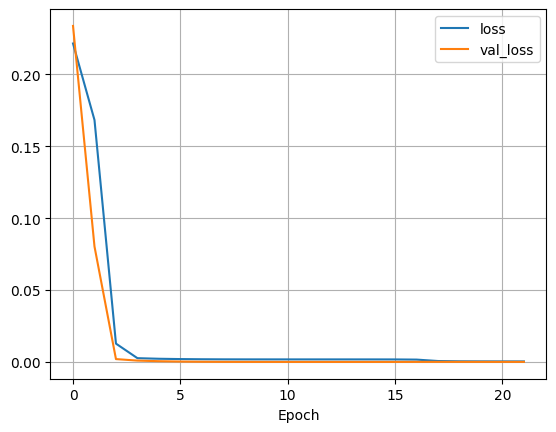

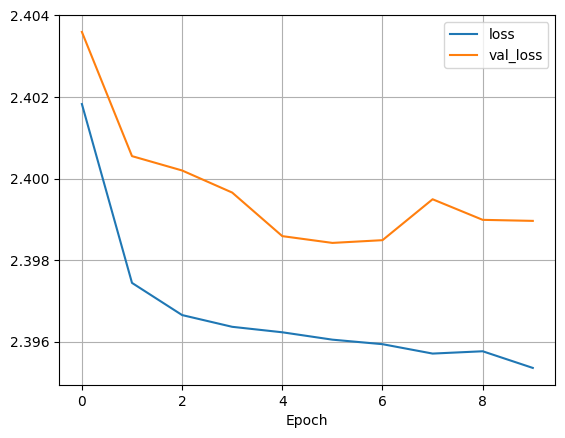

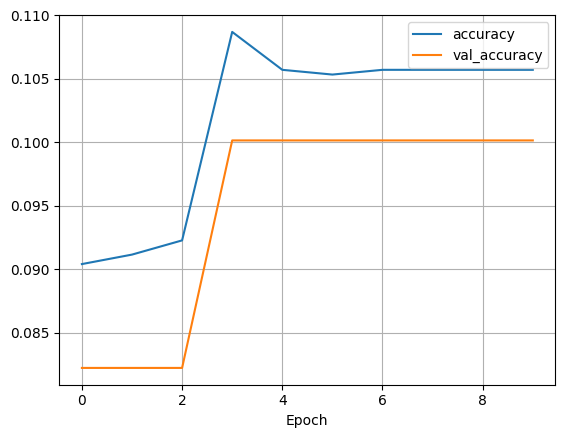

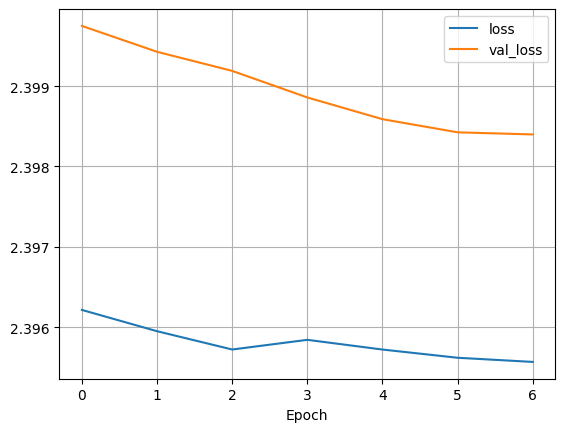

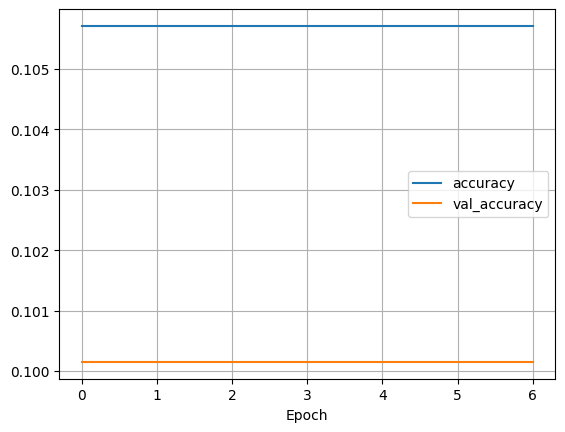

In [25]:
import matplotlib.pyplot as plt

def plot_history(h, keys=("loss","val_loss")):
    plt.figure()
    for k in keys: plt.plot(h.history[k], label=k)
    plt.legend(); plt.xlabel("Epoch"); plt.grid(True)

# CAE (rekonstruksi)
plot_history(history_ae, ("loss","val_loss"))

# CNN stage-1 (head frozen)
plot_history(history_clf_stage1, ("loss","val_loss"))
plot_history(history_clf_stage1, ("accuracy","val_accuracy"))

# CNN stage-2 (unfreeze sebagian)
plot_history(history_clf_stage2, ("loss","val_loss"))
plot_history(history_clf_stage2, ("accuracy","val_accuracy"))
plt.show()


In [27]:
import os

# Create the 'models' directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# simpan model classifier final (struktur+weights)
clf.save("models/hybrid_classifier_savedmodel.keras")

# simpan encoder (untuk reuse / feature extractor)
encoder.save("models/encoder_savedmodel.keras")

# simpan CAE terbaik (optional untuk bab rekonstruksi)
# (jika kamu menyimpan checkpoint CAE sebelumnya)
# tf.keras.models.load_model("cae_best.keras").save("models/cae_savedmodel.keras")